# Project 1: Ames Housing Data

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder as OHE
import scipy as sp

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, mean_squared_error, median_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn import set_config

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [ ]:
df_train

# EDA

### Distribution

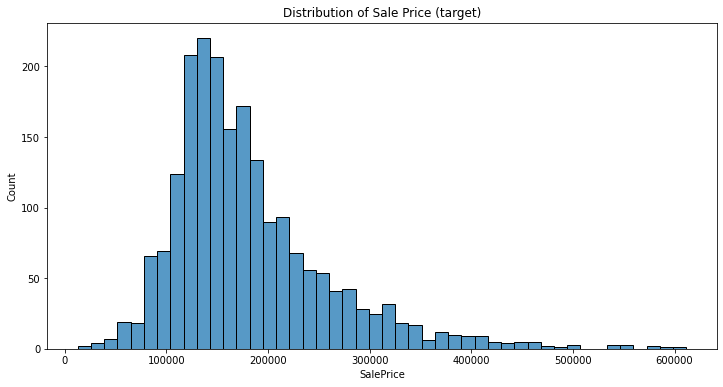

In [3]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of Sale Price (target)')
sns.histplot(data=df_train, x='SalePrice');

# Follows a semi-normal distribution with a right skew and a tail to the right
# Will need to transform target to normalize the Sale Price

### Pairplot

In [4]:
# sns.pairplot(df_train, corner=True)

### Correlation

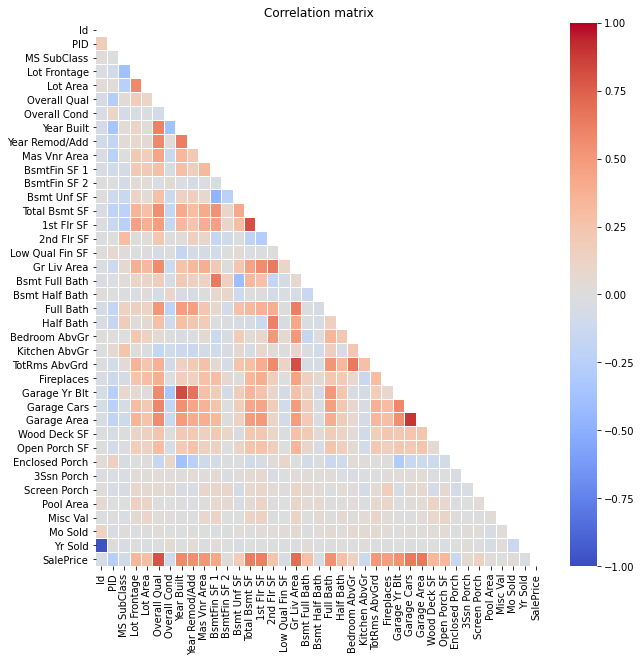

In [5]:
mask = np.zeros_like(df_train.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 10))
sns.heatmap(
    df_train.corr(),
    cmap='coolwarm',
    annot=False,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    linewidths=.01
)
plt.title('Correlation matrix');

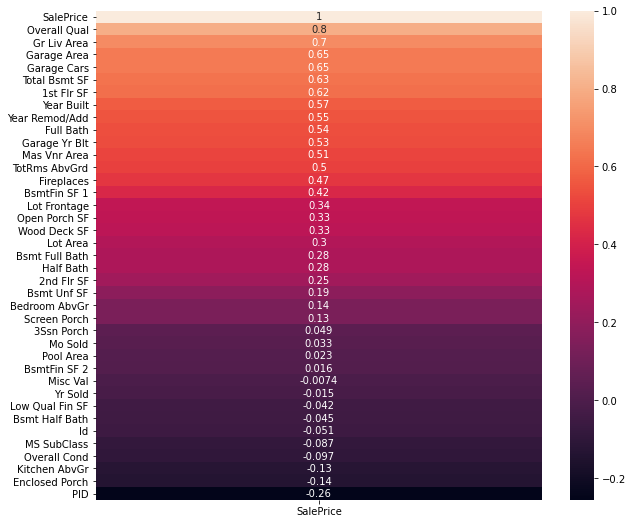

In [6]:
plt.figure(figsize = (10, 9))
sns.heatmap(df_train.corr()[["SalePrice"]].sort_values(by = 'SalePrice', ascending=False), annot=True);

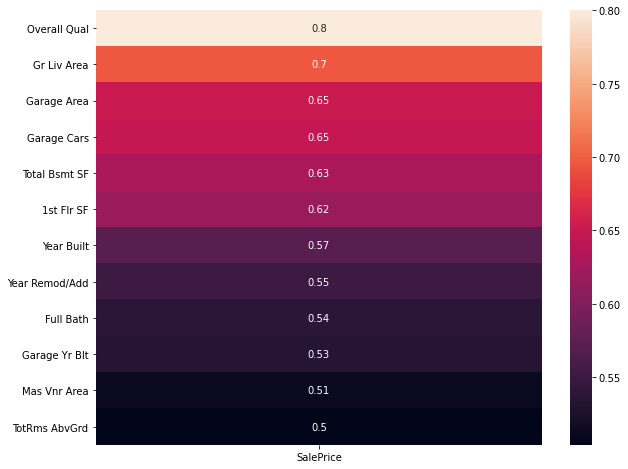

In [7]:
plt.figure(figsize = (10, 8))
sns.heatmap(df_train.corr()[["SalePrice"]].sort_values(by = 'SalePrice', ascending=False)[1:13], annot=True);

### EDA

In [8]:
# very large plot, 81 columns
# sns.pairplot(df_train, corner=True)

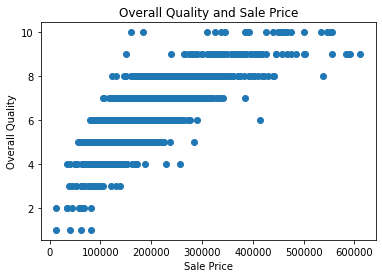

In [9]:
x = df_train['SalePrice']
y = df_train['Overall Qual']

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y)

plt.title('Overall Quality and Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Overall Quality');

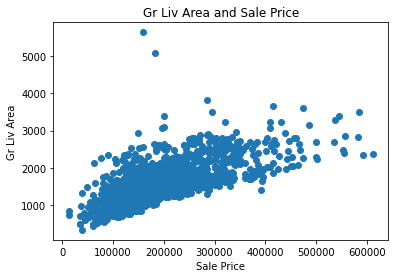

In [10]:
x = df_train['SalePrice']
y = df_train['Gr Liv Area']

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y)

plt.title('Gr Liv Area and Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Gr Liv Area');

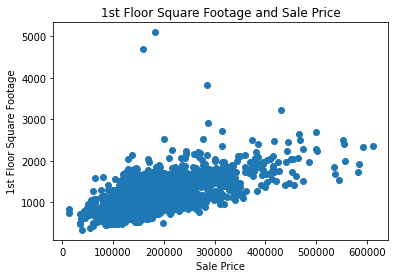

In [11]:
x = df_train['SalePrice']
y = df_train['1st Flr SF']

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y)

plt.title('1st Floor Square Footage and Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('1st Floor Square Footage');

In [12]:
# possible collinearity between some of the square footage features

In [13]:
max_price = df_train['SalePrice'].max()
min_price = df_train['SalePrice'].min()
print(f'Max price is ${max_price}')
print(f'Min price is ${min_price}')

Max price is $611657
Min price is $12789


# Data Cleaning

In [14]:
df_train.info()

# (26) integer columns
# (11) float columns
# (42) object columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [15]:
null = df_train.isnull().sum()
# null

# Drop features with many null values
# will impute features with less than 200 null values

# Drop:
# Alley
# Lot Frontage
# PID
# Fireplace Qu
# Pool QC
# Fence
# Misc Feature

# Also:
# Drop PID column

# Build a Model

### Baseline - Linear Regression with only a few features

In [16]:
# Model with only a few columns that seem to be correlated to Sale Price

X = df_train[['Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train)

print(f'r2 value is {lr_model_1.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, lr_model_1.predict(X_train), squared=False)}')

# df_linear_reg = pd.DataFrame(df_test['Id'])
# df_linear_reg['SalePrice'] = pd.DataFrame(lr_model.predict(y_prediction_train))

r2 value is 0.7282956405317462
rmse value is 40757.32526475976


### More Features + Scaling (linear regression)

In [17]:
X = df_train[['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_1 = make_pipeline(StandardScaler(),  
                     RFE(estimator=LinearRegression(),n_features_to_select=5),
                     LinearRegression())

pipe_1.fit(X_train, y_train)
# pipe_1.score(X_test, y_test)

print(f'r2 value is {pipe_1.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_1.predict(X_train), squared=False)}')

r2 value is 0.784062067175556
rmse value is 36572.00541543597


### Less Features + Scaling (linear regression)

In [18]:
X = df_train[['Overall Qual', 'Gr Liv Area', '1st Flr SF',
                'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Qual', 'Gr Liv Area', '1st Flr SF',
                'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_2 = make_pipeline(StandardScaler(),  
                     RFE(estimator=LinearRegression(),n_features_to_select=5),
                     LinearRegression())

pipe_2.fit(X_train, y_train)
# pipe_2.score(X_train, y_train)

print(f'r2 value is {pipe_2.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_2.predict(X_train), squared=False)}')

r2 value is 0.788653086441193
rmse value is 36513.20347505872


### Linear Model (Scaler, Imputer, RFE)

In [19]:
X = df_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 
                'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 
                'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# col_transformer = make_column_transformer(SimpleImputer(strategy='mean'))

pipe_3 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                     RFE(estimator=LinearRegression(),n_features_to_select=20),
                     LinearRegression())

pipe_3.fit(X_train, y_train)
# pipe_3.score(X_test, y_test)
print(f'r2 value is {pipe_3.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_3.predict(X_train), squared=False)}')

r2 value is 0.7833730614122617
rmse value is 36196.29732772418


### Scaler, Imputer, RFE, GridSearchCV (linear regression)

In [20]:
X = df_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 
                'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 
                'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_4 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                     RFE(estimator=LinearRegression(),n_features_to_select=None),
                     LinearRegression())

params = {'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
linear_grid_1 = GridSearchCV(estimator=pipe_4, param_grid=params, n_jobs=-1)
linear_grid_1.fit(X_train, y_train)

# linear_grid_1.score(X_test, y_test)
print(f'r2 value is {linear_grid_1.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, linear_grid_1.predict(X_train), squared=False)}')

r2 value is 0.8072093864359499
rmse value is 35242.46864372508


### Linear Model with all object features

In [21]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns='SalePrice')
y = df_train['SalePrice']
y_prediction_train = df_test.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_2 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor = LinearRegression(), func=np.log10, inverse_func = sp.special.exp10))

# params = {'transformedtargetregressor__fit_intercept': [True, False], 'transformedtargetregressor__normalize': [True, False]}
# linear_grid = GridSearchCV(estimator=pipe_2, param_grid=params, n_jobs=-1)

pipe_2.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {pipe_2.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_2.predict(X_train), squared=False)}')

r2 value is 0.9164993950677529
rmse value is 22977.241578090885


### Linear Regression with Neighborhoods OneHotEncoded

In [22]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns='SalePrice')
X['Neighborhood'] = df_train[['Neighborhood']]

y = df_train['SalePrice']
y_prediction_train = df_test.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['Neighborhood']))

pipe_3 = make_pipeline(column_trans, StandardScaler(with_mean=False), SimpleImputer(strategy='mean'),
                     RFE(estimator=LinearRegression(),n_features_to_select=10),
                     LinearRegression())

# params = {'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
# linear_grid = GridSearchCV(estimator=pipe_2, param_grid=params, n_jobs=-1)

pipe_3.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {pipe_3.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_3.predict(X_train), squared=False)}')

r2 value is 0.5176492740486786
rmse value is 55060.42371255508


### LinearRegression_Pipe_4

In [23]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')
X_pipe_4 = X
y = df_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_4 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        LinearRegression())

# params = {'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
# linear_grid = GridSearchCV(estimator=pipe_2, param_grid=params, n_jobs=-1)

pipe_4.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {pipe_4.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_4.predict(X_train), squared=False)}')

r2 value is 0.8654059185611703
rmse value is 28817.722847198904


In [24]:
# y_prediction_train = df_test.select_dtypes(exclude=['object'])
# y_prediction_train = y_prediction_train.drop(columns='PID')
# y_prediction_train['Neighborhood'] = df_test[['Neighborhood']]
# y_prediction_train_dummies = pd.get_dummies(y_prediction_train)

# linear_reg_pipe_4 = pd.DataFrame(df_test['Id'])
# linear_reg_pipe_4['SalePrice'] = pd.DataFrame(pipe_4.predict(y_prediction_train_dummies))
# linear_reg_pipe_4.to_csv('./competition_submissions/linear_reg_submission_14.csv', index=False)

# Production Model

### (pipe_production) Linear Model with Dummy variables for Neighborhood, Qual, Type features

In [25]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X['Exter Qual'] = df_train[['Exter Qual']]
X['Bsmt Qual'] = df_train[['Bsmt Qual']]
X['Kitchen Qual'] = df_train[['Kitchen Qual']]
X['Garage Qual'] = df_train[['Garage Qual']]
X['Garage Type'] = df_train[['Garage Type']]
X_production_model = X
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_production = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_production.fit(X_train, y_train)

print(f'r2 value is {pipe_production.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_production.predict(X_train), squared=False)}')

r2 value is 0.8793088346132172
rmse value is 26914.46343570859


In [26]:
# y_production_train = df_test.select_dtypes(exclude=['object'])
# y_production_train = y_prediction_train.drop(columns='PID')
# y_production_train['Neighborhood'] = df_test[['Neighborhood']]
# y_production_train = pd.get_dummies(y_prediction_train)

### Production Model with different features

In [27]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X['Exter Qual'] = df_train[['Exter Qual']]
X['Bsmt Qual'] = df_train[['Bsmt Qual']]
X['Bsmt Cond'] = df_train[['Bsmt Cond']]

X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_5 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_5.fit(X_train, y_train)

print(f'r2 value is {pipe_5.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_5.predict(X_train), squared=False)}')

r2 value is 0.9237649736779602
rmse value is 22313.666682315015


In [28]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X['Exter Qual'] = df_train[['Exter Qual']]
X['Bsmt Qual'] = df_train[['Bsmt Qual']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_5 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_5.fit(X_train, y_train)

print(f'r2 value is {pipe_5.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_5.predict(X_train), squared=False)}')

r2 value is 0.8746832288727868
rmse value is 27635.416582223654


In [29]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X['Exter Qual'] = df_train[['Exter Qual']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_5 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_5.fit(X_train, y_train)

print(f'r2 value is {pipe_5.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_5.predict(X_train), squared=False)}')

r2 value is 0.8616362988237023
rmse value is 29627.359616069545


# Best Model for Kaggle

In [30]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_5 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_5.fit(X_train, y_train)

print(f'r2 value is {pipe_5.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_5.predict(X_train), squared=False)}')

r2 value is 0.8475371490638949
rmse value is 30610.294420701364


In [31]:
# y_prediction_train = df_test.select_dtypes(exclude=['object'])
# y_prediction_train = y_prediction_train.drop(columns='PID')
# y_prediction_train['Neighborhood'] = df_test[['Neighborhood']]
# y_prediction_train_dummies = pd.get_dummies(y_prediction_train)

# linear_reg_pipe_5 = pd.DataFrame(df_test['Id'])
# linear_reg_pipe_5['SalePrice'] = pd.DataFrame(pipe_5.predict(y_prediction_train_dummies))
# linear_reg_pipe_5.to_csv('./competition_submissions/linear_reg_submission_15.csv', index=False)

# Ridge Model

### Ridge Model Scaled, dummy-encoded

In [32]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_5 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        Ridge())

params = {'ridge__alpha': ['.01', '0.1', '1', '10', '100', '200', '500', '1000', '10_000'],
          'ridge__normalize': [True, False]}
linear_grid_ridge = GridSearchCV(estimator=pipe_5, param_grid=params, n_jobs=-1)

linear_grid_ridge.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {linear_grid_ridge.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, linear_grid_ridge.predict(X_train), squared=False)}')

r2 value is 0.8548080459205918
rmse value is 30225.422813891506


In [33]:
cross_val_df = pd.DataFrame(linear_grid_ridge.cv_results_)
cross_val_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_ridge__normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024936,0.004141,0.004984,4.629497e-06,.01,True,"{'ridge__alpha': '.01', 'ridge__normalize': True}",0.885222,0.885373,0.849726,0.468635,0.877931,0.793377,0.162899,7
1,0.017953,0.002601,0.005785,1.715413e-03,.01,False,"{'ridge__alpha': '.01', 'ridge__normalize': Fa...",0.884403,0.884369,0.849157,0.462716,0.870080,0.790145,0.164222,11
2,0.017155,0.000977,0.006183,2.985383e-03,0.1,True,"{'ridge__alpha': '0.1', 'ridge__normalize': True}",0.884340,0.885101,0.853335,0.505854,0.875557,0.800837,0.147937,3
3,0.018949,0.001995,0.005984,1.783847e-03,0.1,False,"{'ridge__alpha': '0.1', 'ridge__normalize': Fa...",0.884437,0.884406,0.849151,0.462724,0.871936,0.790531,0.164409,10
4,0.017952,0.001995,0.005584,1.197219e-03,1,True,"{'ridge__alpha': '1', 'ridge__normalize': True}",0.844738,0.855458,0.836241,0.599109,0.838440,0.794797,0.098071,6
5,0.016756,0.000747,0.004587,4.888698e-04,1,False,"{'ridge__alpha': '1', 'ridge__normalize': False}",0.884670,0.884671,0.849128,0.462930,0.877948,0.791870,0.164993,9
6,0.017154,0.000976,0.004189,3.983512e-04,10,True,"{'ridge__alpha': '10', 'ridge__normalize': True}",0.543378,0.553274,0.544906,0.516155,0.533533,0.538249,0.012702,13
7,0.016357,0.001851,0.005784,2.130447e-03,10,False,"{'ridge__alpha': '10', 'ridge__normalize': False}",0.885174,0.885313,0.849594,0.467523,0.878061,0.793133,0.163334,8
8,0.017354,0.001955,0.004787,3.990660e-04,100,True,"{'ridge__alpha': '100', 'ridge__normalize': True}",0.108914,0.104482,0.105529,0.108862,0.102510,0.106060,0.002505,14
9,0.016357,0.000798,0.004388,4.882672e-04,100,False,"{'ridge__alpha': '100', 'ridge__normalize': Fa...",0.884782,0.885387,0.852880,0.500585,0.876110,0.799949,0.150145,4


### Ridge Model Not Scaled, dummy-encoded

In [34]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_6 = make_pipeline(SimpleImputer(strategy='mean'),
                        Ridge())

params = {'ridge__alpha': ['.01', '0.1', '1', '10', '100', '200', '500', '1000', '10_000'],
          'ridge__normalize': [True, False]}
linear_grid_ridge_2 = GridSearchCV(estimator=pipe_6, param_grid=params, n_jobs=-1)

linear_grid_ridge_2.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {linear_grid_ridge_2.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, linear_grid_ridge_2.predict(X_train), squared=False)}')

r2 value is 0.8845642061012378
rmse value is 26525.580424303203


# Lasso

In [35]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_7 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        Lasso())

# params = {'lasso__alpha': ['.01', '0.1', '1', '10', '100', '200', '500', '1000', '10_000'],
#           'lasso__normalize': [True, False]}

# linear_grid_lasso = GridSearchCV(estimator=pipe_7, param_grid=params, n_jobs=-1)

pipe_7.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {pipe_7.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_7.predict(X_train), squared=False)}')

r2 value is 0.8939823839187818
rmse value is 26181.022510064395


c:\programdata\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158734109040.02197, tolerance: 994378004.5088801
  model = cd_fast.enet_coordinate_descent(


In [36]:
y_prediction_train = df_test.select_dtypes(exclude=['object'])
y_prediction_train = y_prediction_train.drop(columns='PID')
y_prediction_train['Neighborhood'] = df_test[['Neighborhood']]
y_prediction_train_dummies = pd.get_dummies(y_prediction_train)

pipe_7_df = pd.DataFrame(df_test['Id'])
pipe_7_df['SalePrice'] = pd.DataFrame(pipe_7.predict(y_prediction_train_dummies))
pipe_7_df.to_csv('./competition_submissions/lasso_submission_2.csv', index=False)

# Elastic Net

In [37]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

elastic_net_pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        ElasticNet())

elastic_net_pipe.fit(X_train, y_train)

print(f'r2 value is {elastic_net_pipe.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, elastic_net_pipe.predict(X_train), squared=False)}')

r2 value is 0.8546578473374061
rmse value is 30522.136401693508


# KNN Model

In [38]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_8 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        KNeighborsClassifier())

params = {'kneighborsclassifier__n_neighbors': range(3, 31, 2),
          'kneighborsclassifier__p': [0, 1, 2]}
knn_grid = GridSearchCV(estimator=pipe_8, param_grid=params, n_jobs=-1)

knn_grid.fit(X_train, y_train)

# pipe_2.score(X_test, y_test)
print(f'r2 value is {knn_grid.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, knn_grid.predict(X_train), squared=False)}')

c:\programdata\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


r2 value is 0.07022106631989597
rmse value is 54794.59836240256


# Polynomial Features

In [39]:
X = df_train[['Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]
y = df_train['SalePrice']
y_prediction_train = df_test[['Overall Cond', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Fireplaces', 'Year Remod/Add', '1st Flr SF', 'TotRms AbvGrd']]

poly = PolynomialFeatures()
X_poly = poly.fit_transform(X)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y)

sscaler = StandardScaler()
X_poly_train_scaled = sscaler.fit_transform(X_poly_train)
X_poly_test_scaled = sscaler.transform(X_poly_test)

ridge_poly = Ridge()
ridge_poly.fit(X_poly_train_scaled, y_train)
ridge_poly.score(X_poly_test_scaled, y_test)

0.7587895260076871

# Evaluating Models:

### LinearRegression_Pipe_4

In [40]:
print(f'r2 value is {pipe_4.score(X_train, y_train)}')
print(f'rmse value is {mean_squared_error(y_train, pipe_4.predict(X_train), squared=False)}')

r2 value is -0.8843352610232114
rmse value is 107075.06463589327


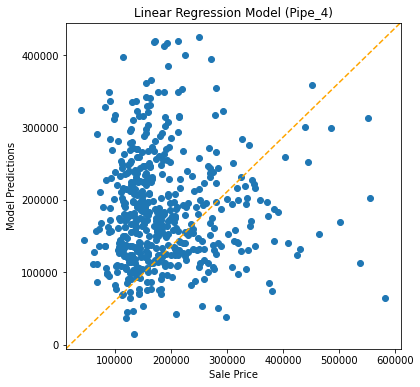

In [41]:
y_pred = pipe_4.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Feature Coefficients

In [42]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')
X_pipe_4 = X
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe_4 = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'),
                        LinearRegression())
pipe_4.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [43]:
feature_names = pd.DataFrame(X_production_model.columns)

In [44]:
X_pipe_4

,Id,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,109,60,NaN,13517,6,8,1976,2005,289.0,533.0,...,0,0,0,0,1,0,0,0,0,0
1,544,60,43.0,11492,7,5,1996,1997,132.0,637.0,...,0,0,0,0,0,1,0,0,0,0
2,153,20,68.0,7922,5,7,1953,2007,0.0,731.0,...,0,0,0,0,0,0,0,0,0,0
3,318,60,73.0,9802,5,5,2006,2007,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,255,50,82.0,14235,6,8,1900,1993,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,20,79.0,11449,8,5,2007,2007,0.0,1011.0,...,0,0,0,0,0,0,0,0,1,0
2047,785,30,NaN,12342,4,5,1940,1950,0.0,262.0,...,0,0,0,0,0,0,0,0,0,0
2048,916,50,57.0,7558,6,6,1928,1950,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2049,639,20,80.0,10400,4,5,1956,1956,0.0,155.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
pipe_4

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [46]:
feature_names=pd.DataFrame(X.columns)
coef = pd.DataFrame(pipe_4.named_steps['linearregression'].coef_)
coef

,0
0,-4236.719379
1,-6234.848986
2,3797.649075
3,5135.778717
4,16222.171679
...,...
58,-12853.000000
59,-9016.625000
60,1131.500000
61,-8139.500000


In [47]:
coefs = pd.DataFrame(pipe_4.named_steps['linearregression'].coef_, columns=['Coefficients'], index=feature_names)
coefs

,Coefficients
"(Id,)",-4236.719379
"(MS SubClass,)",-6234.848986
"(Lot Frontage,)",3797.649075
"(Lot Area,)",5135.778717
"(Overall Qual,)",16222.171679
...,...
"(Neighborhood_SawyerW,)",-12853.000000
"(Neighborhood_Somerst,)",-9016.625000
"(Neighborhood_StoneBr,)",1131.500000
"(Neighborhood_Timber,)",-8139.500000


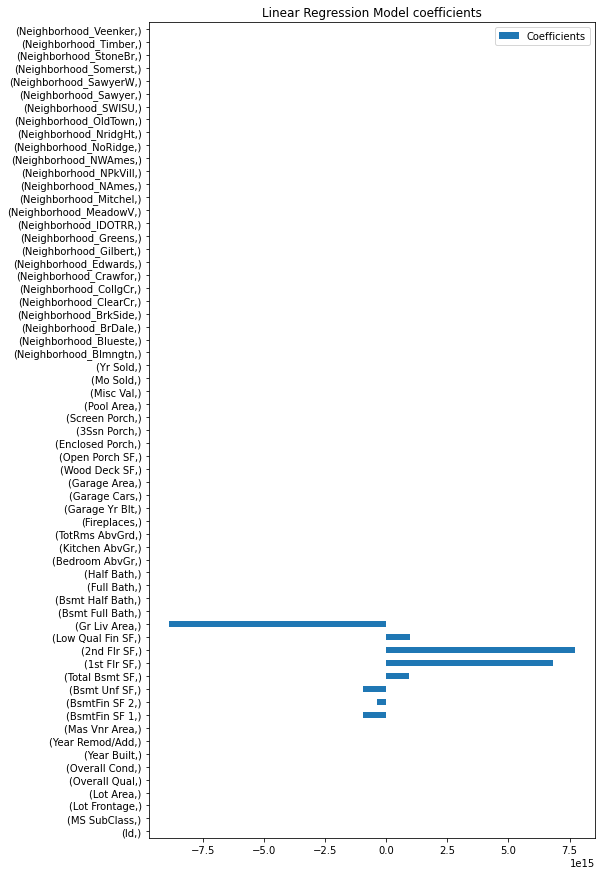

In [48]:
coefs.plot(kind='barh', figsize=(8, 15))
plt.title('Linear Regression Model coefficients');

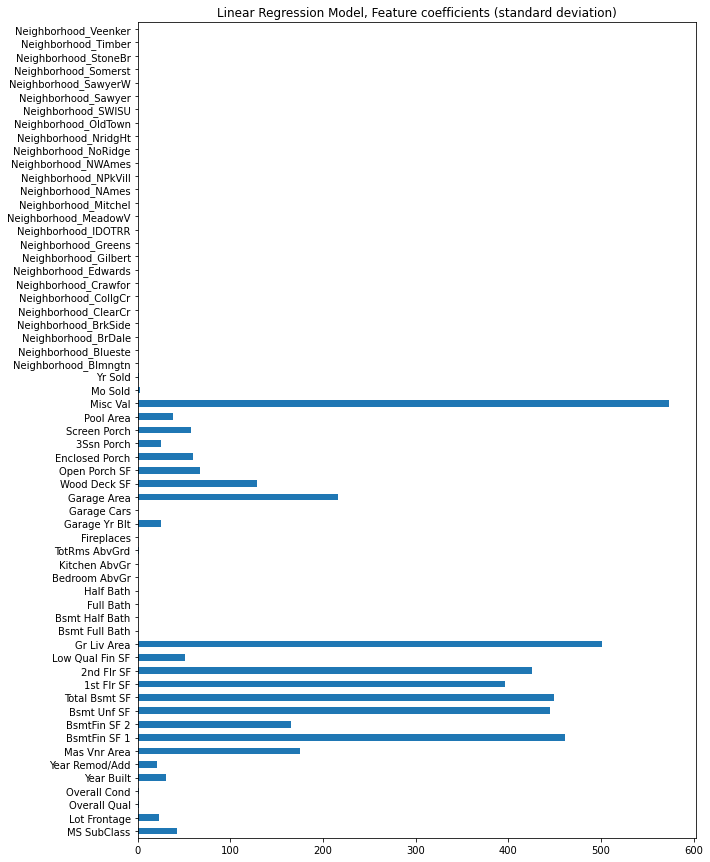

In [49]:
X.drop(columns=['Lot Area', 'Id']).std(axis=0).plot(kind='barh', figsize=(10, 15))
plt.title('Linear Regression Model, Feature coefficients (standard deviation)');

### Production Model

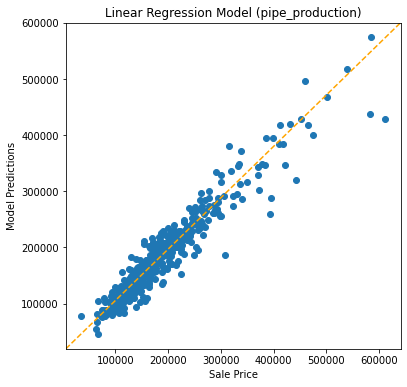

In [51]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X['Exter Qual'] = df_train[['Exter Qual']]
X['Bsmt Qual'] = df_train[['Bsmt Qual']]
X['Kitchen Qual'] = df_train[['Kitchen Qual']]
X['Garage Qual'] = df_train[['Garage Qual']]
X['Garage Type'] = df_train[['Garage Type']]
X_production_model = X
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')

y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe_production = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))

pipe_production.fit(X_train, y_train)

# print(f'r2 value is {pipe_production.score(X_train, y_train)}')
# print(f'rmse value is {mean_squared_error(y_train, pipe_production.predict(X_train), squared=False)}')

y_pred = pipe_production.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (pipe_production)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Linear Regression (pipe_5), best for Kaggle Submission

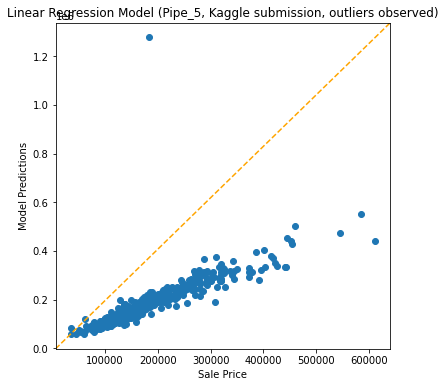

In [52]:
X1 = df_train.select_dtypes(exclude=['object'])
X = X1.drop(columns=['SalePrice', 'PID'])
X['Neighborhood'] = df_train[['Neighborhood']]
X = pd.get_dummies(X)
X = X.drop(columns='Neighborhood_GrnHill')
X = X.drop(columns='Neighborhood_Landmrk')
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe_5 = make_pipeline(StandardScaler(), 
                       SimpleImputer(strategy='mean'),
                       TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))
pipe_5.fit(X_train, y_train)
# print(f'r2 value is {pipe_5.score(X_train, y_train)}')
# print(f'rmse value is {mean_squared_error(y_train, pipe_5.predict(X_train), squared=False)}')

y_pred = pipe_5.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_5, Kaggle submission, outliers observed)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Kaggle Submission, removed outlier and scaled X and y from 0-600,000

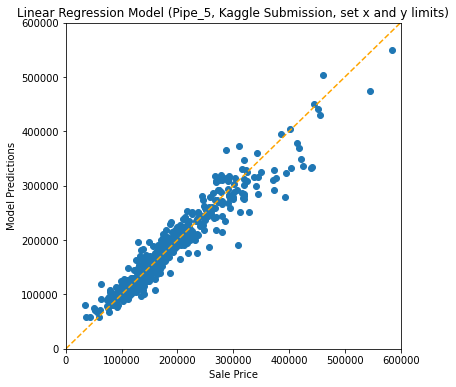

In [53]:
y_pred = pipe_5.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_5, Kaggle Submission, set x and y limits)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions')

plt.xlim([0, 600000])
plt.ylim([0, 600000]);

### Ridge Model

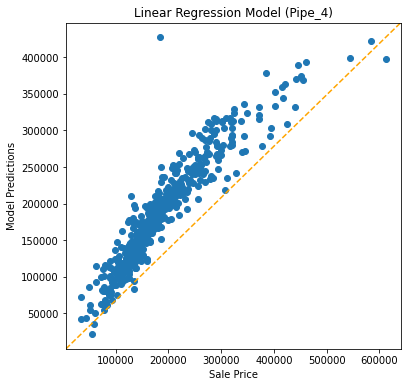

In [54]:
y_pred = linear_grid_ridge.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Ridge Model, not scaled

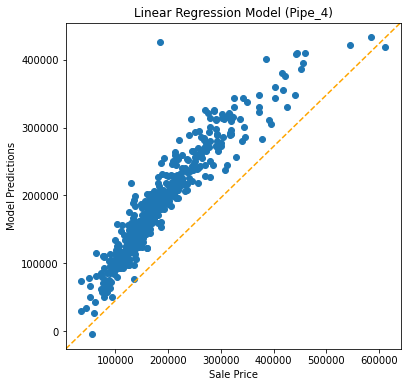

In [55]:
y_pred = linear_grid_ridge_2.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Lasso

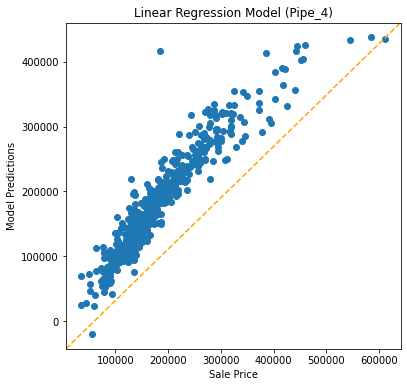

In [56]:
y_pred = pipe_7.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### Elastic Net

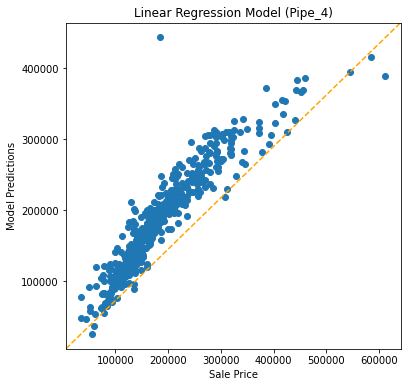

In [57]:
y_pred = elastic_net_pipe.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

### KNN Model

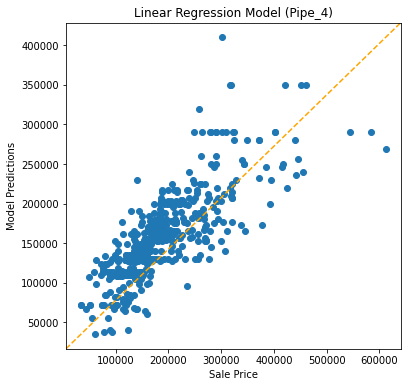

In [58]:
y_pred = knn_grid.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")

plt.title('Linear Regression Model (Pipe_4)')
plt.xlabel('Sale Price')
plt.ylabel('Model Predictions');

# Conclusions and Recommendations

A linear regression model can account for data in approximately 85-90% of the data.

In the production model, the actual and predicted prices were consistent among the dataset, but the model tended to predict higher values for the sale price. 

For the Kaggle model, most predictions were somewhat accurate compared to the actual price, however there were a few outliers (one prediction noticible at ~\\$2.5 M) which may indicate it this model does not perform well in all situations.

The ridge, lasso, elastic net, and KNN models were somewhat accurate but tended to be be less accurate at higher priced houses.

Looking at the scaled feature weights, some features such as garage area,  gr liv area, 2nd/1st floor area, and basement square footage seem to be strong indicators in the models.

Factors that may may affect home price include:
- Features dealing with area/square footage
    - Gr Liv Area
    - Garage Area
    - Garage Cars
    - Total Bsmt SF
    - 1st Flr SF
    - Size and amount of beds/baths
- Quality parameters
    - Overall Qual
    - Exter Qual
    - Bsmt Qual
    - Kitchen Qual
    - Garage Qual
    - Garage Type
- Neighborhood

Additional research may be needed to evaluate any collinearity and to deal with any outliers in some of the features, as well as some of the models.

In addition, updated data bay provide new insights based on more recent house sale trends.